Q.1 CNN Visualization

In [1]:
#Import necessary libraries
import numpy as np
import cv2
import torchvision
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.models import resnet50, ResNet50_Weights
import torchvision.transforms as transforms
from PIL import Image
import warnings
warnings.filterwarnings("ignore")

In [2]:
#Load pre-trained ResNet50 model
resnet_model = torchvision.models.resnet50(weights='DEFAULT', progress=True)

#Get default transforms for the ResNet50 model
resnet_transforms = ResNet50_Weights.DEFAULT.transforms()

#Define helper function for min-max normalization
def normalize(arr: np.ndarray) -> np.ndarray:
    """
    Min-max normalizes a numpy array
    """
    return (arr - arr.min()) / (arr.max() - arr.min())

#Define function to add heatmap over the image
def add_heatmap(img: np.ndarray, heatmap: np.ndarray) -> np.ndarray:
    """
    Add the heatmap over the input image.
    """
    # Normalize the heatmap
    heatmap = np.uint8(normalize(heatmap) * 255)

    # Apply color map to the heatmap
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_HOT)

    # Convert the heatmap color space to RGB
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    # Normalize the input image
    img = np.uint8(normalize(img) * 255)

    # Combine the image and heatmap using weighted addition
    img_with_heatmap = 0.67 * img + 0.33 * heatmap

    # Normalize the output image
    return np.uint8(normalize(img_with_heatmap) * 255)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to C:\Users\relat/.cache\torch\hub\checkpoints\resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

KeyboardInterrupt: 

In [66]:
def backprop(image, model, transform) -> np.ndarray:
    """
    Computes the backpropagation for the given image and model
    """
    # Putting model in evaluation mode
    model.eval()
    
    # Reading the image and setting requires_grad to True 
    image = transform(image)
    image.requires_grad_()
    
    # Adding the batch dimension and getting the predicted class index
    score = model(image.unsqueeze(0)).max()

    # Performing backward to get the gradients wrt image
    score.backward()
    
    # Getting the gradients and converting them to a numpy array
    gradients = image.grad.numpy()

    # Returning by doing a min-max normalization
    return normalize(gradients)

In [67]:
#Function to perform a ReLU on the backpropagated gradients
def backward_relu_hook(module, grad_in, grad_out):
    if isinstance(module, torch.nn.ReLU):
        return (torch.clamp(grad_in[0], min=0.),)
    
#List to store hook handles
hook_handles = []

#Function to register backward hooks for ReLU layers in a given model
def register_relu_backward_hooks(model):

    # Iterate over child modules of the model
    for child in model.children():
        # Check if the child module is a ReLU layer
        if isinstance(child, torch.nn.ReLU):
            
            global hook_handles
            # Register a backward hook for the ReLU layer and store the hook handle
            hook_handles.append(child.register_backward_hook(backward_relu_hook))

        # If the child module is not a ReLU layer, recursively call this function on it
        else:
            register_relu_backward_hooks(child)

In [68]:
def guided_backprop(image, model, transform, to_normalize: bool = True) -> np.ndarray:
    """
    Computes the guided backpropagation for the given image and model
    """
    global hook_handles
    # Putting model in evaluation mode
    model.eval()
    
    # Registering the hooks
    register_relu_backward_hooks(model)

    # Reading the image and setting requires_grad to True 
    image = transform(image)
    image.requires_grad_()
    
    # Adding the batch dimension and getting the maximum score
    score = model(image.unsqueeze(0)).max()

    # Performing backward to get the gradients wrt image
    score.backward()
    
    # Getting the gradients and converting them to a numpy array
    gradients = image.grad.numpy()

    # Removing all the hooks
    for handle in hook_handles:
        handle.remove()

    # Returning by doing a min-max normalization if requested
    if to_normalize:
        gradients = normalize(gradients)
    
    return gradients

In [69]:
# Initialize an empty list to store the output
out = []

# Function to get the output of the last ReLU layer
def forward_hook_CAM(model, input, output):
    global out
    out = output

# Function to compute Class Activation Maps (CAM) for a given image and model
def compute_CAM(img, model, transform):
    
    # Register a forward hook on the ReLU of the last layer
    layer4_relu = model.layer4[2].relu
    layer4_relu.register_forward_hook(forward_hook_CAM)
    
    # Set the model to evaluation mode
    model.eval()
    
    img_tensor = transform(img)
    img_tensor.requires_grad_() 
    
    # Compute the prediction for the input image
    img_pred = model(img_tensor.unsqueeze(0))
    
    # Find the index of the predicted class with the highest score
    index = torch.argmax(img_pred).item()             
    
    # Get the weights of the max index from the fully-connected (FC) layer
    fc_wt = model.fc.weight
    fc_wt = fc_wt[index,:].reshape(1,-1,1,1)
    
    # Multiply the activation maps with the weights of the FC layer
    global out
    prod = fc_wt * out                             
    
    # Sum along the channel dimension
    sum = torch.sum(prod,axis=1)
    sum = sum.detach().unsqueeze(0)
    
    # Interpolate the activation maps to the size of the input image
    sum = torch.nn.functional.interpolate(sum, size=(img_tensor.shape[1],img_tensor.shape[2]),mode='bilinear')
    
    return sum.squeeze(0).squeeze(0)

In [70]:
# Global lists to capture activation and gradient values
activation_list, gradient_list = [], []

def forward_hook_grad(module, input, output):
    """Forward hook to capture activation values from ReLU layers."""
    if isinstance(module, torch.nn.ReLU):
        global activation_list
        activation_list.append(output)

def backward_hook_grad(module, grad_in,grad_out):                       
    """Backward hook to capture gradient values from ReLU layers."""
    if isinstance(module, torch.nn.ReLU):
        global gradient_list
        gradient_list.append(grad_in[0])

def guided_grad_cam(image, model, transform):
    """Guided Grad-CAM function that combines guided backpropagation and Grad-CAM to produce a heatmap image
    of the regions that are important for the model's prediction.

    Args:
        image (PIL.Image): The input image.
        model (torch.nn.Module): The trained PyTorch model.
        transform (torchvision.transforms.transforms.Compose): The image transformation pipeline.

    Returns:
        np.ndarray: The guided Grad-CAM heatmap image.
    """
    global activation_list, gradient_list
    model.eval()

    # Register the forward and backward hooks on the ReLU layer of the last convolutional block
    forward_handle =  model.layer4[-1].relu.register_forward_hook(forward_hook_grad)
    backward_handle = model.layer4[-1].relu.register_backward_hook(backward_hook_grad)

    # Convert the PIL image to Torch tensor and get the model's prediction
    img_trans = transform(image)
    prediction = model(img_trans.unsqueeze(0))
    index = prediction.argmax()
    
    # Compute the gradient of the prediction w.r.t the activations of the last convolutional block
    prediction[:, index].backward()
    
    # Remove the hooks
    forward_handle.remove()
    backward_handle.remove()

    # Compute the Grad-CAM heatmap
    required_weights = gradient_list[0].mean((2,3), True)
    required_activation = activation_list[-1]*required_weights
    grad_cam = required_activation.sum(axis=1)
    grad_cam = torch.relu(grad_cam)

    # Resize the heatmap to the size of the input image and normalize it
    grad_cam = torch.nn.functional.interpolate(grad_cam.unsqueeze(0), size=(224,224), mode='bilinear')
    grad_cam = grad_cam[0,0].detach().numpy()
    grad_cam = normalize(grad_cam)

    # Combine the guided backpropagation and Grad-CAM to produce the guided Grad-CAM heatmap
    guided_back = guided_backprop(image, model, transform, False)

    guidedGradCAM = np.multiply(guided_back, grad_cam)

    return normalize(guidedGradCAM)

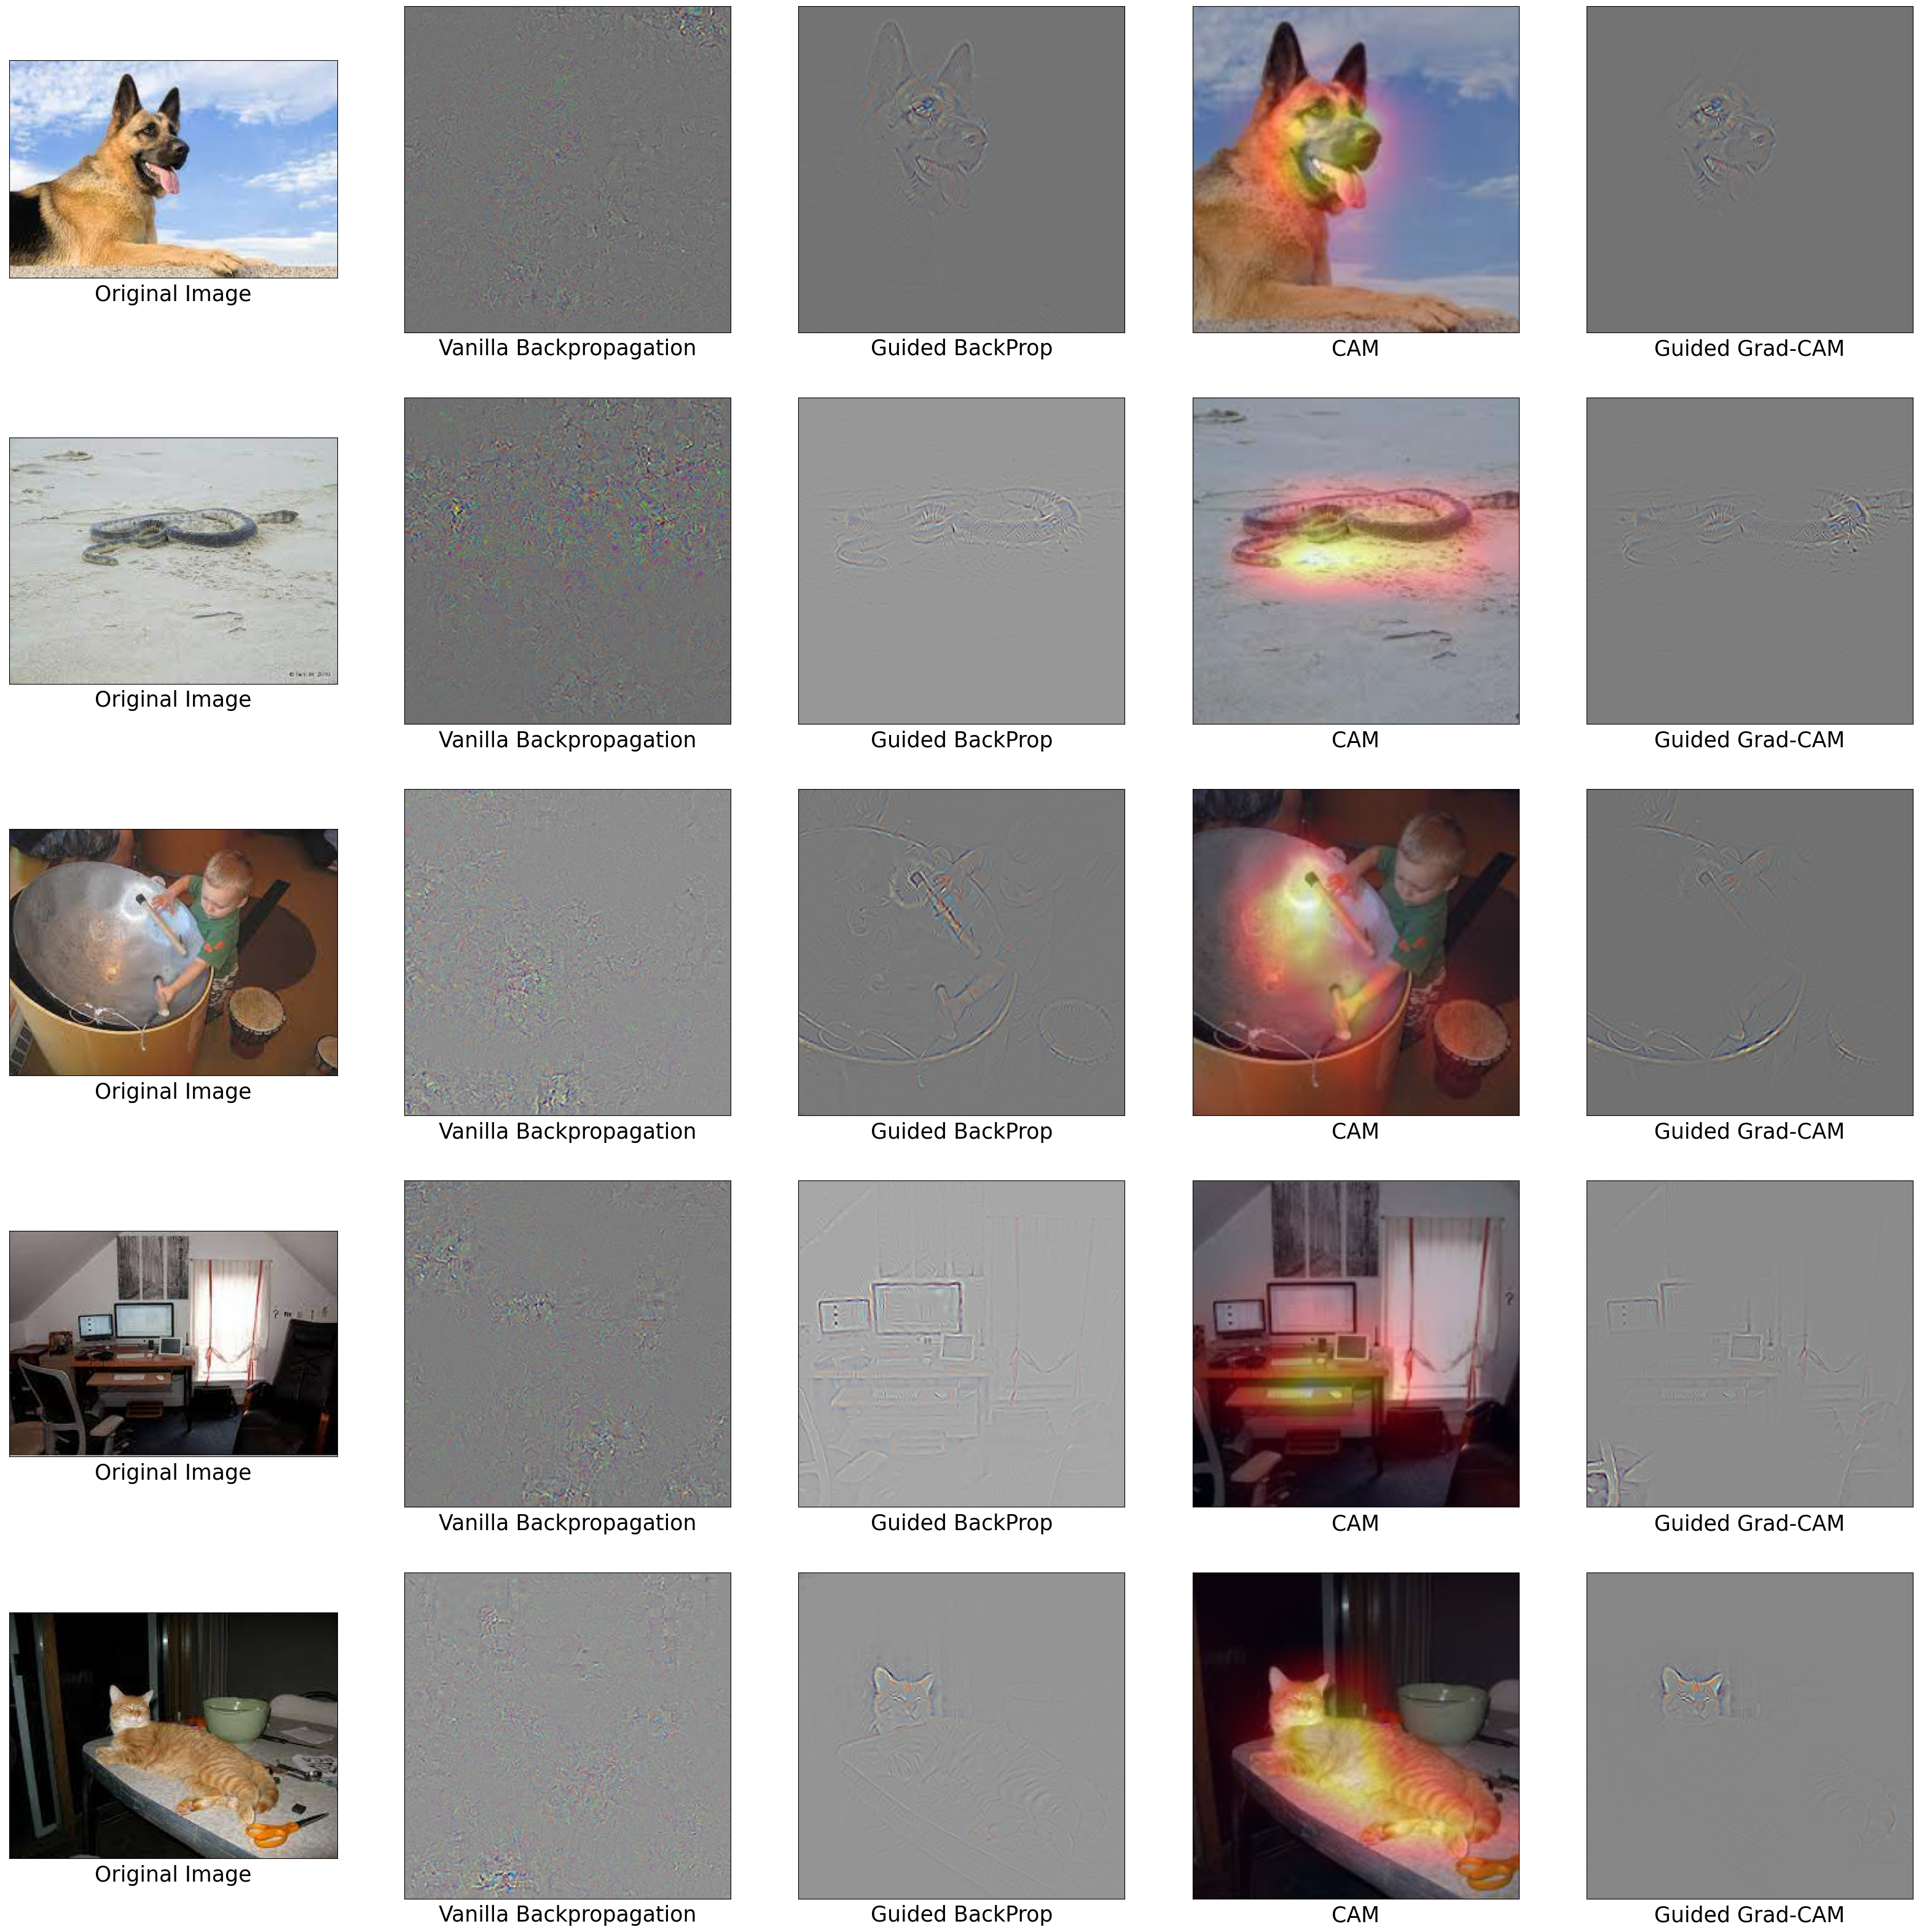

In [71]:
img = [Image.open(f"i{i}.jpg") for i in range(1,6)]

fig, ax = plt.subplots(5, 5, figsize=(40, 40))
for i in range(5):

    ## Showing the image ##
    ax[i, 0].imshow(img[i])
    ax[i, 0].set_xticks([]); ax[i, 0].set_yticks([])
    ax[i, 0].set_xlabel('Original Image')
    ax[i, 0].xaxis.label.set_fontsize(25)

    ## Vanilla Backpropagation ##
    vanilla = backprop(img[i], resnet_model, resnet_transforms)
    ax[i, 1].imshow(vanilla.transpose(1, 2, 0))
    ax[i, 1].set_xticks([]); ax[i, 1].set_yticks([])
    ax[i, 1].set_xlabel('Vanilla Backpropagation')
    ax[i, 1].xaxis.label.set_fontsize(25)

    ## Guided BackProp ##
    guidedback = guided_backprop(img[i], resnet_model, resnet_transforms)
    ax[i, 2].imshow(guidedback.transpose(1, 2, 0))
    ax[i, 2].set_xticks([]); ax[i, 2].set_yticks([])
    ax[i, 2].set_xlabel('Guided BackProp')
    ax[i, 2].xaxis.label.set_fontsize(25)

    ## CAM ##
    cam = compute_CAM(img[i], resnet_model, resnet_transforms)
    image = resnet_transforms(img[i]).detach().numpy().transpose(1, 2, 0)
    img_CAM = add_heatmap(image, cam)
    ax[i, 3].imshow(img_CAM)
    ax[i, 3].set_xticks([]); ax[i, 3].set_yticks([])
    ax[i, 3].set_xlabel('CAM')
    ax[i, 3].xaxis.label.set_fontsize(25)

    ## Guided Grad-CAM ##
    guidedgradcam = guided_grad_cam(img[i], resnet_model, resnet_transforms)
    ax[i, 4].imshow(guidedgradcam.transpose(1, 2, 0))
    ax[i, 4].set_xticks([]); ax[i, 4].set_yticks([])
    ax[i, 4].set_xlabel('Guided Grad-CAM')
    ax[i, 4].xaxis.label.set_fontsize(25)

Q.2 SGD Update rule variations

In [72]:
import numpy as np
import matplotlib.pyplot as plt

In [73]:
def objective_function(x,y):
    return(10*x**2.0+y**2.0)
def grad(x,y):
    return np.array([20*x,2*y])

In [74]:
def vanilla_sgd(func=objective_function, learn_param=None, grad=grad):
    # Initialize the parameter randomly
    xy_parameter = [-18,18]
    
    # Create a list to store the parameter values in each iteration
    xarr = [xy_parameter]
    
    # Iterate for 50 times
    for i in range(0, 50):
        # Initialize a temporary array to store the new parameter values
        temp = np.empty(2)
        
        # Compute the gradient using the grad function with the current parameter values
        g = grad(xy_parameter[0], xy_parameter[1])
        
        # Update the parameter using the vanilla stochastic gradient descent rule
        temp = xy_parameter - learn_param * g
        
        # Store the new parameter values in the xarr list
        xarr.append(temp)
        
        # Update the parameter for the next iteration
        xy_parameter = temp
    
    # Return the list of parameter values in each iteration
    return xarr

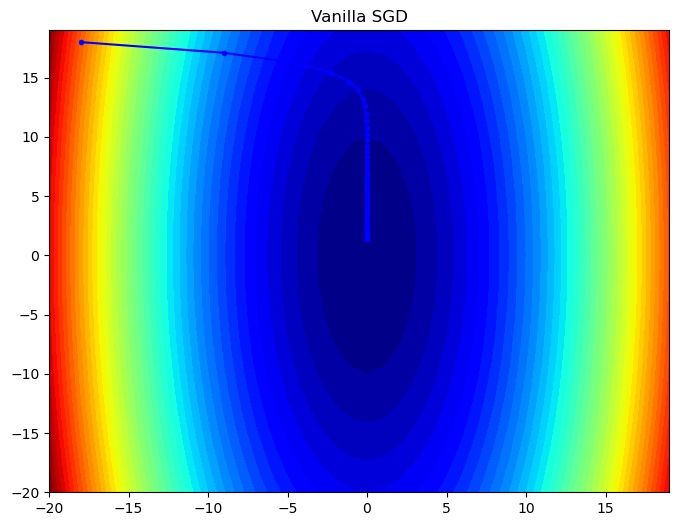

In [75]:
result_gd = vanilla_sgd(func=objective_function,learn_param=0.025,grad=grad)

# Plotting
# --------------------------------
fig = plt.figure(figsize=(8, 6))
xaxis = np.arange(-20,20 ,1)
yaxis = np.arange(-20,20 ,1)
xGrid, yGrid = np.meshgrid(xaxis, yaxis)
results = objective_function(xGrid, yGrid)
plt.title("Vanilla SGD")
plt.contourf(xGrid, yGrid, results, levels=50, cmap='jet')
plt.plot(np.array(result_gd)[:,0],np.array(result_gd)[:,1], '.-', color='blue', label ='Vanilla SGD')
#---------------------
plt.show()

In [76]:
def momentum_update(rho, momentum_pre, grad, learn_param):
    # Update the momentum vector
    momentum_pre = momentum_pre * rho + learn_param * grad
    return momentum_pre

# Define the main function for stochastic gradient descent with momentum
def sgd_momentum(func=objective_function, learn_param=0.01, momentum=0.9):
    # Initialize the starting parameter values
    prev_parameter = [-18,18]
    # Initialize the momentum vector to all zeros
    momentum_vec = np.zeros(2)
    # Store the starting parameter values in a list
    y_arr = [prev_parameter]
    # Loop for a fixed number of iterations
    for i in range(0, 50):
        # Compute the gradient using the current parameter values
        g = grad(prev_parameter[0], prev_parameter[1])
        # Define the value of rho inside the loop
        rho = 0.9
        # Update the momentum vector using the current gradient and momentum value
        momentum_vec = momentum_update(rho, momentum_vec, g, learn_param)
        # Compute the new parameter values using the updated momentum vector
        temp = prev_parameter - momentum_vec
        # Store the new parameter values in the list
        y_arr.append(temp)
        # Update the previous parameter values to the new values
        prev_parameter = temp
    # Return the list of parameter values
    return y_arr



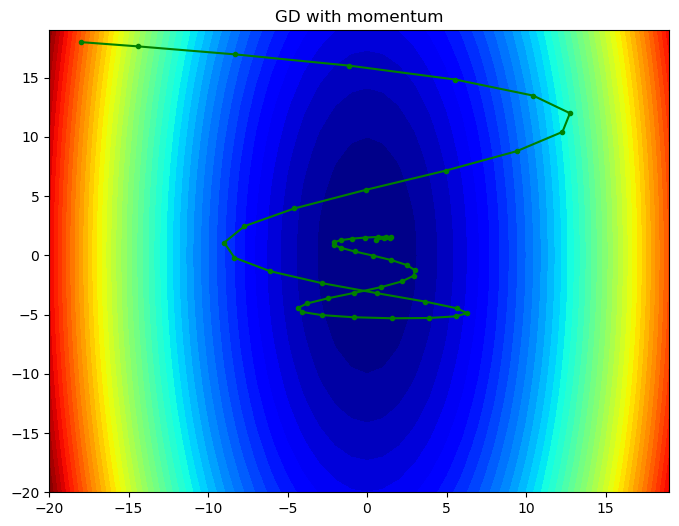

In [77]:
result_gd_momemtum = sgd_momentum(func=objective_function, learn_param=0.01, momentum=0.9)

# Plotting
# --------------------------------
fig = plt.figure(figsize=(8, 6))
plt.title("GD with momentum")
plt.contourf(xGrid, yGrid, results, levels=50, cmap='jet')
plt.plot(np.array(result_gd_momemtum)[:,0],np.array(result_gd_momemtum)[:,1], '.-', color='green', label ='GD with momentum')
#---------------------
plt.show()

In [78]:
def adaptive_gradient_descent(func, gradient, bounds, n_iter, step_size):
    """
    Perform Adaptive Gradient Descent algorithm on given function.
    :param func: function to be minimized
    :param gradient: gradient of the function
    :param bounds: boundary conditions for the solution
    :param n_iter: number of iterations to perform
    :param step_size: step size for each iteration
    :return: array of solutions obtained during each iteration
    """
    solutions = []
    solution = np.array([-18,18]) # Initial solution
    squared_gradient_sums = [0.0 for _ in range(bounds.shape[0])]
    
    # Perform n_iter iterations
    for iteration in range(1, n_iter+1):
        # Calculate gradient at current solution
        grad = gradient(solution[0], solution[1])
        
        # Calculate squared sum of gradients for each dimension
        for i in range(grad.shape[0]):
            squared_gradient_sums[i] += grad[i]**2.0 
        
        # Update solution using calculated step size
        new_solution = []
        for i in range(solution.shape[0]):
            alpha = step_size / (1e-8 + np.sqrt(squared_gradient_sums[i]))
            value = solution[i] - alpha * grad[i]
            new_solution.append(value)
        solution = np.array(new_solution)
        solutions.append(solution.copy())
    
    return np.array(solutions)


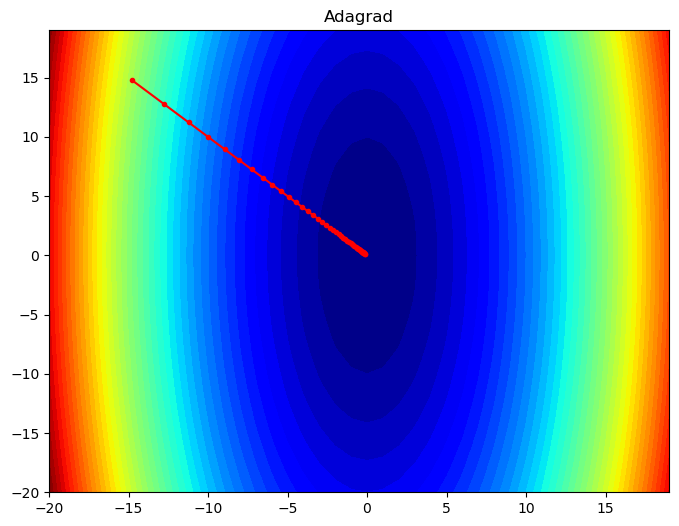

In [79]:
result_ada= adaptive_gradient_descent(objective_function, grad, np.array([[-20.0, 20.0], [-20.0, 20.0]]), n_iter = 50, step_size = 3.2)

# Plotting
# --------------------------------
fig = plt.figure(figsize=(8, 6))
plt.title("Adagrad")
plt.contourf(xGrid, yGrid, results, levels=50, cmap='jet')
plt.plot(np.array(result_ada)[:,0],np.array(result_ada)[:,1], '.-', color='red', label ='Adagrad')
#---------------------
plt.show()

In [80]:
# Define the Nesterov Gradient update function
def nag_update(rho, momentum_pre, learn_param, x):
    # Compute the tentative next position and momentum vector
    x_next_tentative = x - rho*momentum_pre
    # Compute the gradient at the tentative next position
    grad_next_tentative = grad(x_next_tentative[0], x_next_tentative[1])
    # Update the momentum vector using the gradient at the tentative next position
    momentum_pre = rho * momentum_pre + learn_param * grad_next_tentative
    # Compute the next position
    x_next = x - momentum_pre
    return x_next, momentum_pre

# Define the main function for Nesterov Accelerated Gradient
def nag(func=objective_function, learn_param=0.005, momentum=0.9):
    # Initialize the starting parameter values
    prev_parameter = [-18,18]
    # Initialize the momentum vector to all zeros
    momentum_vec = np.zeros(2)
    # Store the starting parameter values in a list
    y_arr = [prev_parameter]
    # Loop for a fixed number of iterations
    for i in range(0, 50):
        # Compute the gradient using the current parameter values
        g = grad(prev_parameter[0], prev_parameter[1])
        # Define the value of rho inside the loop
        rho = 0.9
        # Update the parameter values and momentum vector using the NAG update
        temp, momentum_vec = nag_update(rho=rho,momentum_pre= momentum_vec, learn_param=learn_param,x= prev_parameter)
        # Store the new parameter values in the list
        y_arr.append(temp)
        # Update the previous parameter values to the new values
        prev_parameter = temp
    # Return the list of parameter values
    return y_arr


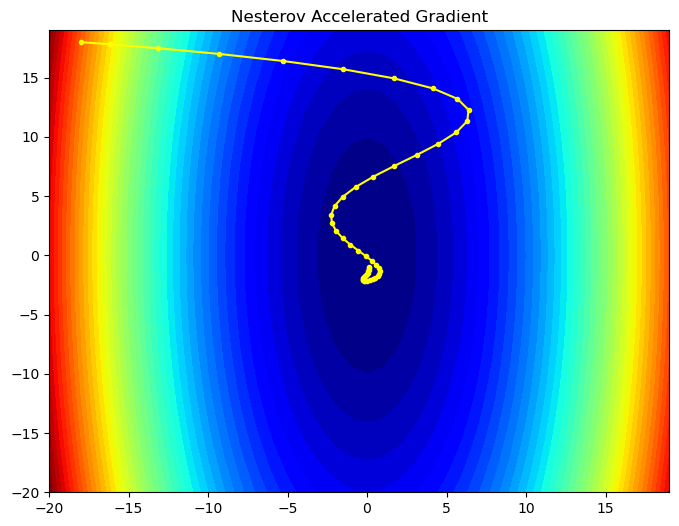

In [81]:
# i=nag()
result_nesterov = nag()

# Plotting
# --------------------------------
fig = plt.figure(figsize=(8, 6))
plt.title("Nesterov Accelerated Gradient")
plt.contourf(xGrid, yGrid, results, levels=50, cmap='jet')
plt.plot(np.array(result_nesterov)[:,0],np.array(result_nesterov)[:,1], '.-', color='yellow', label ='Nesterov Accelerated Gradient')
#---------------------
plt.show()

In [82]:
def rmsprop_optimization(objective_func, gradient_func, bounds, num_iterations, step_size, rho=0.99):
    """
    Performs RMSProp optimization to minimize the given objective function within the specified bounds.

    Args:
        objective_func (function): The objective function to be minimized.
        gradient_func (function): The gradient of the objective function.
        bounds (numpy array): The lower and upper bounds for the optimization variables.
        num_iterations (int): The number of iterations to run the optimization.
        step_size (float): The step size for the optimization.
        rho (float, optional): The decay rate for the moving average of squared gradients. Defaults to 0.99.

    Returns:
        numpy array: An array of solutions found during the optimization process.
    """
    # Initialize starting solution and average squared gradient
    current_solution = [-18,18]
    avg_sq_grad = np.zeros_like(current_solution)
    solutions = [current_solution.copy()]

    # Run optimization iterations
    for i in range(1, num_iterations+1):
        gradient = gradient_func(*current_solution)
        sq_grad = gradient ** 2
        avg_sq_grad = rho * avg_sq_grad + (1 - rho) * sq_grad
        alpha = step_size / np.sqrt(avg_sq_grad + 1e-8)
        new_solution = np.clip(current_solution - alpha * gradient, bounds[:, 0], bounds[:, 1])
        solutions.append(new_solution.copy())
        current_solution = new_solution

    return np.array(solutions)


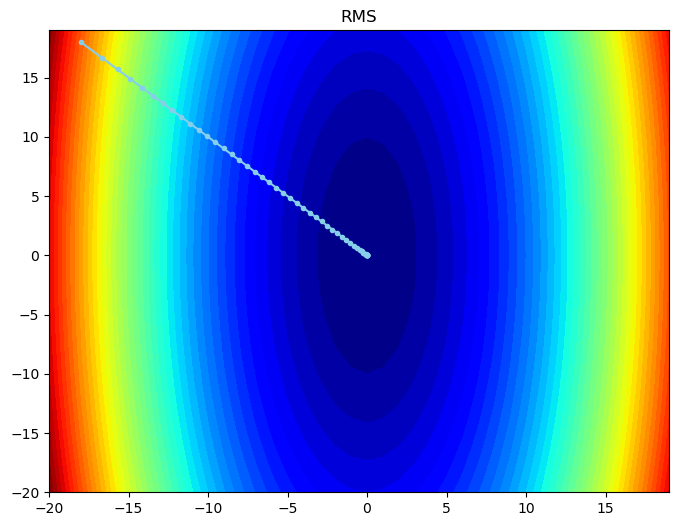

In [83]:
result_rms= rmsprop_optimization(objective_function, grad, np.array([[-20.0, 20.0], [-20.0, 20.0]]), num_iterations = 50, step_size = 0.6, rho= 0.8)

# Plotting
# --------------------------------
fig = plt.figure(figsize=(8, 6))
plt.title("RMS")
plt.contourf(xGrid, yGrid, results, levels=50, cmap='jet')
plt.plot(np.array(result_rms)[:,0],np.array(result_rms)[:,1], '.-', color='skyblue', label ='RMS')
#---------------------
plt.show()

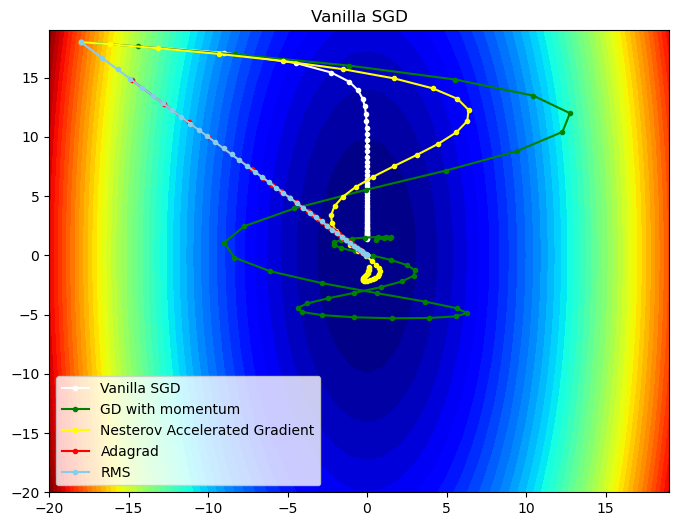

In [84]:
# Plotting the function
#---------------------------------------------
fig = plt.figure(figsize=(8, 6))
xaxis = np.arange(-20,20 ,1)
yaxis = np.arange(-20,20 ,1)
xGrid, yGrid = np.meshgrid(xaxis, yaxis)
results = objective_function(xGrid, yGrid)
plt.title("Vanilla SGD")
plt.contourf(xGrid, yGrid, results, levels=50, cmap='jet')

plt.plot(np.array(result_gd)[:,0],np.array(result_gd)[:,1], '.-', color='white', label ='Vanilla SGD')
plt.plot(np.array(result_gd_momemtum)[:,0],np.array(result_gd_momemtum)[:,1], '.-', color='green', label ='GD with momentum')
plt.plot(np.array(result_nesterov)[:,0],np.array(result_nesterov)[:,1], '.-', color='yellow', label ='Nesterov Accelerated Gradient')
plt.plot(np.array(result_ada)[:,0],np.array(result_ada)[:,1], '.-', color='red', label ='Adagrad')
plt.plot(np.array(result_rms)[:,0],np.array(result_rms)[:,1], '.-', color='skyblue', label ='RMS')


#---------------------
plt.legend()
plt.show()


In [85]:
# Generating the GIF 
#-----------------------
import imageio
time = np.arange(0,50,1)

def create_frame(t):
    fig = plt.figure(figsize=(10, 6))
    xaxis = np.arange(-20,20 ,1)
    yaxis = np.arange(-20,20 ,1)
    xGrid, yGrid = np.meshgrid(xaxis, yaxis)
    results = objective_function(xGrid, yGrid)
    plt.title("Vanilla SGD")
    plt.contourf(xGrid, yGrid, results, levels=50, cmap='jet')

    plt.plot(np.array(result_gd)[:t,0],np.array(result_gd)[:t,1], '.-', color='blue', label ='Vanilla SGD')
    plt.plot(np.array(result_gd_momemtum)[:t,0],np.array(result_gd_momemtum)[:t,1], '.-', color='green', label ='GD with momentum')
    plt.plot(np.array(result_nesterov)[:t,0],np.array(result_nesterov)[:t,1], '.-', color='yellow', label ='Nesterov Accelerated Gradient')
    plt.plot(np.array(result_ada)[:t,0],np.array(result_ada)[:t,1], '.-', color='red', label ='Adagrad')
    plt.plot(np.array(result_rms)[:t,0],np.array(result_rms)[:t,1], '.-', color='skyblue', label ='RMS')
    plt.legend()

    plt.savefig(f'./Anjesh/img_{t}.png', transparent = False, facecolor = 'white')
    plt.close()

for t in time:
    create_frame(t)

frames = []
for t in time:
    image = imageio.v2.imread(f'./Anjesh/img_{t}.png')
    frames.append(image)

imageio.mimsave('./anjesh.gif', # output gif
                frames,          # array of input frames
                fps = 10)       # optional: frames per second
